<center>
    <p style="text-align:center">
    <img alt="arize logo" src="https://storage.googleapis.com/arize-assets/arize-logo-white.jpg" width="300"/>
        <br>
        <a href="https://docs.arize.com/arize/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/client_python">GitHub</a>
        |
        <a href="https://arize-ai.slack.com/join/shared_invite/zt-11t1vbu4x-xkBIHmOREQnYnYDH1GDfCg">Slack Community</a>
    </p>
</center>

# <center>Arize Prompt Experimentation</center>

This guide demonstrates how to use Arize for logging and analyzing prompt iteration experiments with your LLM. We're going to build a simple prompt experimentation pipeline that generates outputs using different variations of a base prompt. The generated outputs will be logged to an Arize dataset along with the corresponding prompt used. Arize makes it easy to track and compare results from prompt iteration experiments, allowing you to identify which prompt variations yield the best performance. You can read more about experiment tracking with Arize here.
In this tutorial, you will:

*   Set up an Arize dataset to log the prompts and generated outputs from our experiments

*   Create a base prompt and define a set of variations to experiment with

*   Implement a script that iterates through the prompt variations, generates outputs using an LLM, and logs each prompt-output pair to the Arize dataset

*   Analyze the logged data in Arize to compare results across prompt variations and identify the best performing prompts

By leveraging Arize for experiment tracking, you'll be able to systematically test different prompt variations at scale and use the logged data to inform your prompt engineering process. Let's get started!

ℹ️ This notebook requires:
- An OpenAI API key
- An Arize Space ID & Developer Key (explained below)

# Step 1: Setup Config

Copy the Arize developer API Key and Space ID from the Datasets page (shown below) to the variables in the cell below.

<center><img src="https://storage.googleapis.com/arize-assets/fixtures/dataset_api_key.png" width="700"></center>

In [ ]:
from uuid import uuid1
from getpass import getpass
import os

# FROM Datasets UI #
SPACE_ID = globals().get("SPACE_ID") or getpass(
    "🔑 Enter your Arize Space ID: "
)
API_KEY = globals().get("API_KEY") or getpass("🔑 Enter your Arize API Key: ")
DEVELOPER_KEY = globals().get("DEVELOPER_KEY") or getpass(
    "🔑 Enter your Arize Developer Key: "
)
OPENAI_API_KEY = globals().get("OPENAI_API_KEY") or getpass(
    "🔑 Enter your OpenAI API key: "
)
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
###################
dataset_name = "docs-qa-new-" + str(uuid1())[:5]

Install dependencies

In [ ]:
!pip install -q "arize[Datasets]>7.29.0" openai==1.57.1 datasets==3.2.0 pyarrow==18.1.0 pydantic==2.10.3 nest_asyncio==1.6.0 tiktoken==0.8.0 rouge==1.0.1 "arize-phoenix-evals>=0.17.5"

Let's make sure we can run async code in the notebook.

In [ ]:
import nest_asyncio

nest_asyncio.apply()

## Step 2: Download Data


Download your [data](https://huggingface.co/datasets/abisee/cnn_dailymail) from HuggingFace and inspect a random sample of ten rows. This dataset contains news articles and human-written summaries that we will use as a reference against which to compare our LLM generated summaries.

Upload the data as a **dataset** in Arize and inspect the individual **examples** of the dataset. Later in the notebook, you will run **experiments** over this dataset in order to iteratively improve your summarization application.

In [ ]:
from datetime import datetime

from datasets import load_dataset

hf_ds = load_dataset("abisee/cnn_dailymail", "3.0.0")
df = (
    hf_ds["test"]
    .to_pandas()
    .sample(n=10, random_state=0)
    .set_index("id")
    .rename(columns={"article": "input", "highlights": "summary"})
)
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

In [ ]:
from arize.experimental.datasets import ArizeDatasetsClient
from arize.experimental.datasets.utils.constants import GENERATIVE


arize_client = ArizeDatasetsClient(developer_key=DEVELOPER_KEY, api_key=API_KEY)
# Create a dataset from a DataFrame add your own data here
dataset_id = arize_client.create_dataset(
    space_id=SPACE_ID,
    dataset_name=dataset_name,
    dataset_type=GENERATIVE,
    data=df,
)
dataset_name

In [ ]:
dataset = arize_client.get_dataset(space_id=SPACE_ID, dataset_id=dataset_id)
dataset.head()

## Define Your Experiment Task

A **task** is a callable that maps the input of a dataset example to an output by invoking a chain, query engine, or LLM. An **experiment** maps a task across all the examples in a dataset and optionally executes **evaluators** to grade the task outputs.

First, define a function to format a prompt template and invoke an OpenAI model on an example.

In [ ]:
from openai import OpenAI
from typing import Dict, Any

client = OpenAI()


def summarize_article_openai(
    dataset_row, prompt_template: str, model: str
) -> Dict[str, str]:
    input_text = dataset_row["input"]
    reference_summary = dataset_row["summary"]
    formatted_prompt_template = prompt_template.format(article=input_text)
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "assistant", "content": formatted_prompt_template},
        ],
    )
    assert response.choices
    generated_summary = response.choices[0].message.content
    return {
        "output": generated_summary,
        "expected": {"summary": reference_summary},
    }

From this function, you can use functools.partial to derive your first task, which is a callable that takes in an example and returns an output.

In [ ]:
from functools import partial

template = """
Summarize the article in two to four sentences:

ARTICLE
=======
{article}

SUMMARY
=======
"""
gpt_4o = "gpt-4o-2024-05-13"
task = partial(summarize_article_openai, prompt_template=template, model=gpt_4o)

## Define Your Evaluators

Evaluators take the output of a task (in this case, a string) and grade it, often with the help of an LLM. In your case, you will create ROUGE score evaluators to compare the LLM-generated summaries with the human reference summaries you uploaded as part of your dataset. There are several variants of ROUGE, but we'll use ROUGE-1 for simplicity:

- ROUGE-1 precision is the proportion of overlapping tokens (present in both reference and generated summaries) that are present in the generated summary (number of overlapping tokens / number of tokens in the generated summary)
- ROUGE-1 recall is the proportion of overlapping tokens that are present in the reference summary (number of overlapping tokens / number of tokens in the reference summary)
- ROUGE-1 F1 score is the harmonic mean of precision and recall, providing a single number that balances these two scores.

Higher ROUGE scores mean that a generated summary is more similar to the corresponding reference summary. Scores near 1 / 2 are considered excellent, and a [model fine-tuned on this particular dataset achieved a rouge score of ~0.44](https://huggingface.co/datasets/abisee/cnn_dailymail#supported-tasks-and-leaderboards).

Since we also care about conciseness, you'll also define an evaluator to count the number of tokens in each generated summary.

Note that you can use any third-party library you like while defining evaluators (in your case, `rouge` and `tiktoken`).

In [ ]:
from typing import Dict
import tiktoken
from rouge import Rouge


# convenience functions
def _rouge_1(hypothesis: str, reference: str) -> Dict[str, Any]:
    scores = Rouge().get_scores(hypothesis, reference)
    return scores[0]["rouge-1"]


def _rouge_1_f1_score(hypothesis: str, reference: str) -> float:
    return _rouge_1(hypothesis, reference)["f"]


def _rouge_1_precision(hypothesis: str, reference: str) -> float:
    return _rouge_1(hypothesis, reference)["p"]


def _rouge_1_recall(hypothesis: str, reference: str) -> float:
    return _rouge_1(hypothesis, reference)["r"]


def rouge_1_f1_score(result: Dict[str, Any]) -> float:
    return _rouge_1_f1_score(
        hypothesis=result["output"], reference=result["expected"]["summary"]
    )


def rouge_1_precision(result: Dict[str, Any]) -> float:
    return _rouge_1_precision(
        hypothesis=result["output"], reference=result["expected"]["summary"]
    )


def rouge_1_recall(result: Dict[str, Any]) -> float:
    return _rouge_1_recall(
        hypothesis=result["output"], reference=result["expected"]["summary"]
    )


def num_tokens(result: Dict[str, Any]) -> int:
    encoding = tiktoken.encoding_for_model(gpt_4o)
    return len(encoding.encode(result["output"]))


EVALUATORS = [rouge_1_f1_score, rouge_1_precision, rouge_1_recall, num_tokens]

Test out your evaluator by testing it on a test example.

In [ ]:
test_example = dataset.iloc[0]
test_result = task(test_example)
print("Generated Summary:", test_result["output"])
print("Reference Summary:", test_result["expected"]["summary"])

# Test an evaluator
print("ROUGE-1 F1 Score:", rouge_1_f1_score(test_result))

## Run Experiments and Iterate on Your Prompt Template


Run your first experiment with the first prompt template.

In [ ]:
experiment = arize_client.run_experiment(
    space_id=SPACE_ID,
    dataset_id=dataset_id,
    task=task,
    evaluators=EVALUATORS,
    experiment_name="initial-template",
)

Our initial prompt template contained little guidance. It resulted in an ROUGE-1 F1-score just above 0.3 (this will vary from run to run). Inspecting the task outputs of the experiment, you'll also notice that the generated summaries are far more verbose than the reference summaries. This results in high ROUGE-1 recall and low ROUGE-1 precision. Let's see if we can improve our prompt to make our summaries more concise and to balance out those recall and precision scores while maintaining or improving F1. We'll start by explicitly instructing the LLM to produce a concise summary.

In [ ]:
template = """
Summarize the article in two to four sentences. Be concise and include only the most important information.

ARTICLE
=======
{article}

SUMMARY
=======
"""
task = partial(summarize_article_openai, prompt_template=template, model=gpt_4o)
experiment_results = arize_client.run_experiment(
    space_id=SPACE_ID,
    dataset_id=dataset_id,
    task=task,
    evaluators=EVALUATORS,
    experiment_name="concise-template",
)

Inspecting the experiment results, you'll notice that the average `num_tokens` has indeed increased, but the generated summaries are still far more verbose than the reference summaries.

Instead of just instructing the LLM to produce concise summaries, let's use a few-shot prompt to show it examples of articles and good summaries. The cell below includes a few articles and reference summaries in an updated prompt template.

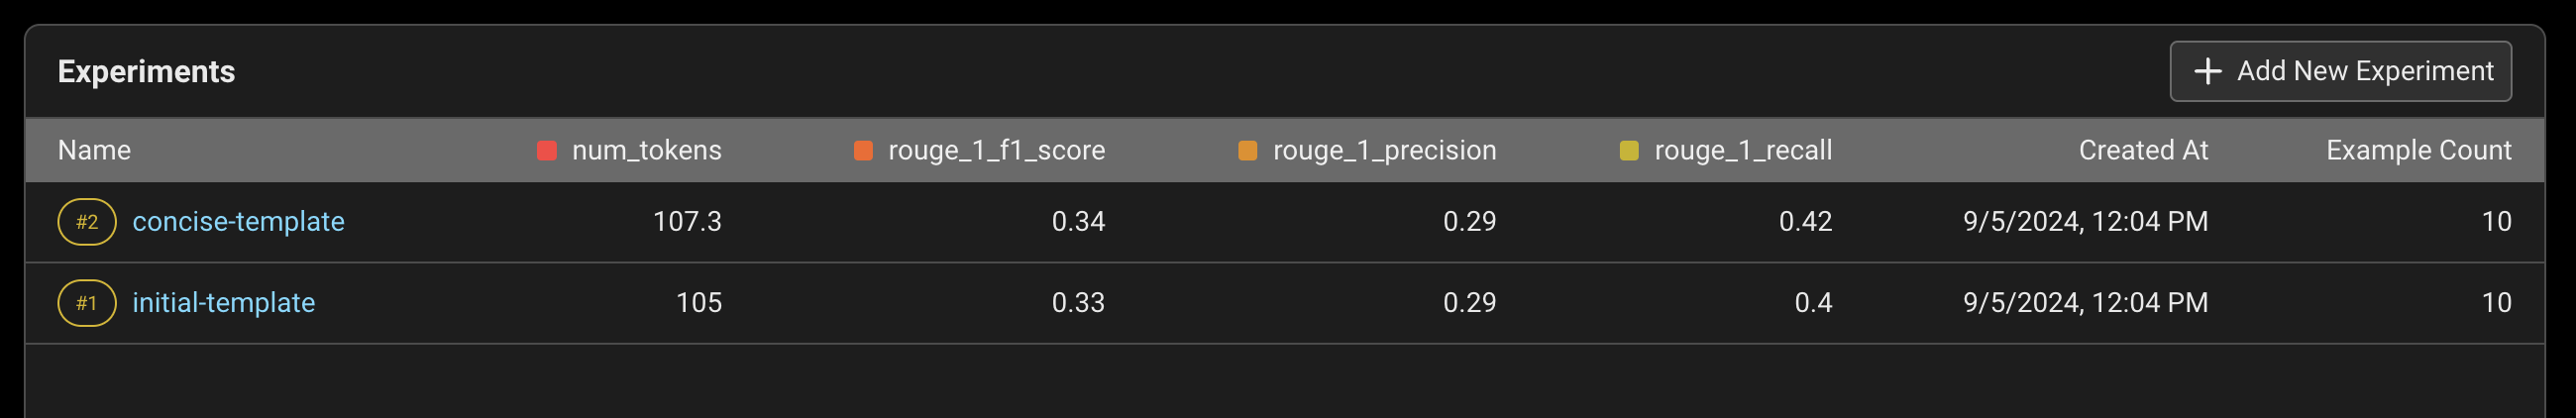

In [ ]:
# examples to include (not included in the uploaded dataset)
train_df = (
    hf_ds["train"]
    .to_pandas()
    .sample(n=5, random_state=42)
    .head()
    .rename(columns={"highlights": "summary"})
)

example_template = """
ARTICLE
=======
{article}

SUMMARY
=======
{summary}
"""

examples = "\n".join(
    [
        example_template.format(article=row["article"], summary=row["summary"])
        for _, row in train_df.iterrows()
    ]
)

template = """
Summarize the article in two to four sentences. Be concise and include only the most important information, as in the examples below.

EXAMPLES
========

{examples}


Now summarize the following article.

ARTICLE
=======
{article}

SUMMARY
=======
"""

template = template.format(
    examples=examples,
    article="{article}",
)
print(template)

Now run the experiment.

In [ ]:
task = partial(summarize_article_openai, prompt_template=template, model=gpt_4o)
experiment_results = arize_client.run_experiment(
    space_id=SPACE_ID,
    dataset_id=dataset_id,
    task=task,
    evaluators=EVALUATORS,
    experiment_name="few-shot-template",
)

By including examples in the prompt, you'll notice a steep decline in the number of tokens per summary while maintaining F1.